In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cvxopt import spmatrix, matrix, solvers

from scipy.sparse import bsr_matrix, eye, kron, hstack, vstack
from scipy.spatial.distance import cdist
from time import time

# Linear programming formulation

Suppose we have two non-negative denisties $f_i$, for $i = 1, 2, \cdots , m$, $g_j$ for $j = 1, 2, \cdots , n$ where 

$$\sum_i^m f_i = \sum_j^n g_j$$


on the unit interval $[0,1]$ with $c_{ij}$ the vector of squared distances between points $i$ and $j$. 

The we wish to find mapping $T_{ij}$ so that to minimise 

$$ \sum_i^m \sum_j^n c_{ij} T_{ij}$$

subject to 

$$\sum_j^n T_{ij} = f_i, \qquad \sum_i^m T_{ij} = g_y$$
$$$$

where 

$$T_{ij} \geq 0.$$

In matrix form this is a standard linear programming 

$$\text{minimise } c \cdot x$$

subject to 

$$Ax = b, \qquad \text{for} \qquad x \geq 0$$

where $A$ is the contraint matrix, $x$ is the mapping $T_{ij}$ and $b = [f_1, \cdots , f_m, g_1, \cdots, g_n]$.

In [2]:
def _normalise(density):
    return density / float(np.sum(density))

In [3]:
def _coeff_matrix(m, n):
    a = hstack([kron(eye(m), np.ones(n)), bsr_matrix(np.ones((m, 1)))])
    b = hstack([kron(np.ones(m), eye(n)), bsr_matrix(np.zeros((n, 1)))])
    A = vstack([a, b]).tocoo()
    return spmatrix(A.data.tolist(), A.row.tolist(), A.col.tolist(), size=(m + n, m * n + 1))

In [4]:
def _1dcost(source, target):
    cost = []
    m, n = len(source), len(target)
    x1 = np.linspace(0, 1, m)
    y1 = np.linspace(0, 1, n)

    for i in range(m):
        for j in range(n):
            cost.append((x1[i] - y1[j]) ** 2)
    cost.append(0)
    
    return cost

# Example of optimal transport problem

Optimal transport between source and target densites $f(x)$,  $g(y)$ has a mapping $T(x)$ that satisfies the PDE 

$$\lvert\det(\nabla T(x))\rvert g(T(x)) = f(x)$$ 

that maps $f(x)$ onto $g(y)$. An optimal transport distance, known as the Wasserstein distance can be defined as $$W = \int_X \lvert x - T(x) \rvert^2 f(x)dx$$. 

From literature (see Villani) we know the mapping $T(x)$ has the form 

$$T(x) = \nabla \phi = \nabla\left(\frac{x^2}{2} - \psi\right).$$

A couple of examples.. 

Let $f(x) = 2x$ and $g(y) = 1$, where $x \in X$, $y \in Y$ and $X=Y=[0,1]$, then the PDE becomes 

$$ \nabla T(x) = \phi_{xx} = 2x.$$

Integrating.. 

$$ \nabla T(x) = \phi_{x} = x^2 = T(x).$$

Then to find the cost

$$W = \int_0^1 \lvert x - x^2 \rvert^2 2x dx  = \frac{1}{30} \approx 0.0333.$$



Or alternatively (Villani), we know that 

$$T(x) = G^{-1}(F(x)),$$

where, $F(x)$ and $G(y)$ are the cumulative density functions of $f(x)$ and $g(y)$ respectively. So 

$$F(x) = \int_0^x 2 \xi d \xi = x^2$$
$$G(y) = \int_0^y d \eta = y = G^{-1}(y)$$

So $T(x) = G^{-1}(F(x)) = x^2$. 

In [5]:
m, n = 32, 32

source = 2 * np.array(list(range(m))) / float(m-1)
target = np.ones(n)

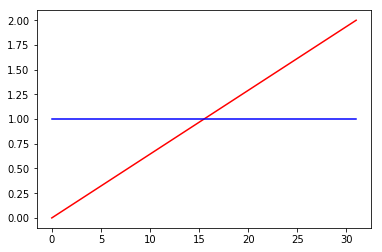

In [6]:
plt.plot(source, color = 'r')
plt.plot(target, color = 'b')

In [7]:
# Set up LP problem & solve 

A = _coeff_matrix(m, n)

b = matrix(np.r_[_normalise(source), _normalise(target)])

c = matrix(_1dcost(source, target))

G = spmatrix(-1.0, range(m * n + 1), range(m * n + 1))

h = matrix(np.zeros(n*m+1)) # Ensure x \geq 0

t0 = time()
solution = solvers.lp(c, G, h, A, b, solver='mosek')
t1 = time()

x = solution['x']

print('\n' + 'Solver time: ' + str(t1 - t0))


# Approximation to Wasserstein distance

print('\n' + 'Cost: ' + str(x.T*c))


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1089            
  Cones                  : 0               
  Scalar variables       : 1025            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1089            
  Cones                  :

# 2D example of same problem 

Solution is the same. Much above $32 \times 32$ density is too big to reasonably solve. 

The linear programming formula is exactly the same if we flatten our 2D densities to vectors and construct a 2D cost function instead.

In [8]:
def _2dcost(source, target):
    m1, m2 = source.shape
    n1, n2 = target.shape
# create meshgrids on domain [0,1] x [0,1]
    X1, X2 = np.linspace(0, 1, m1), np.linspace(0, 1, m2)
    Y1, Y2 = np.linspace(0, 1, n1), np.linspace(0, 1, n2)
    x1, x2 = np.meshgrid(X1, X2)
    y1, y2 = np.meshgrid(Y1, Y2)
# coordinate array
    coords_x = np.c_[x1.flatten(), x2.flatten()]
    coords_y = np.c_[y1.flatten(), y2.flatten()]
# pairwise distance between coordinates
    cost = np.append(cdist(coords_x, coords_y, 'sqeuclidean').flatten(), 0)
    return cost

In [9]:
m1, m2 = 32, 32
n1, n2 = 32, 32

M = m1 * m2
N = n1 * n2

source = 2 * np.array(list(range(m1))) / float(m1-1)
source = np.tile(source, (m2, 1))

target = np.ones((n1, n2))

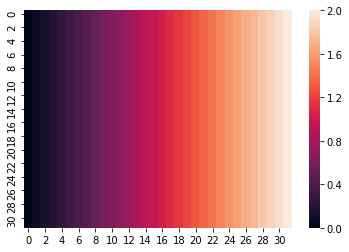

In [10]:
sns.heatmap(source)

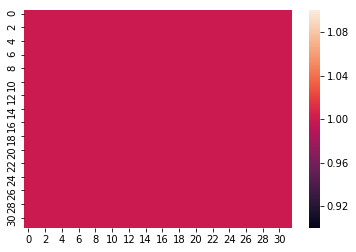

In [11]:
sns.heatmap(target)

In [12]:
# Set up LP problem & solve 

A = _coeff_matrix(M, N)

b = matrix(np.r_[_normalise(source.flatten('F')), _normalise(target.flatten('F'))])

c = matrix(_2dcost(source, target))

# Ensure x \geq 0 or in cvxopt Gx \leq h

G = spmatrix(-1.0, range(M * N + 1), range(M * N + 1)) 

h = matrix(np.zeros(M * N + 1)) 

t0 = time()
solution = solvers.lp(c, G, h, A, b, solver='mosek')
t1 = time()

x = solution['x']

print('\n' + 'Solver time: ' + str(t1 - t0))

# Approximation to Wasserstein distance

print('\n' + 'Cost: ' + str(x.T*c))

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1050625         
  Cones                  : 0               
  Scalar variables       : 1048577         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.24            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 1.79    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1050625         
  Cones                  :

In [13]:
res = np.array(x)

In [14]:
sol = np.reshape(res[:-1], (32**2, 32**2))

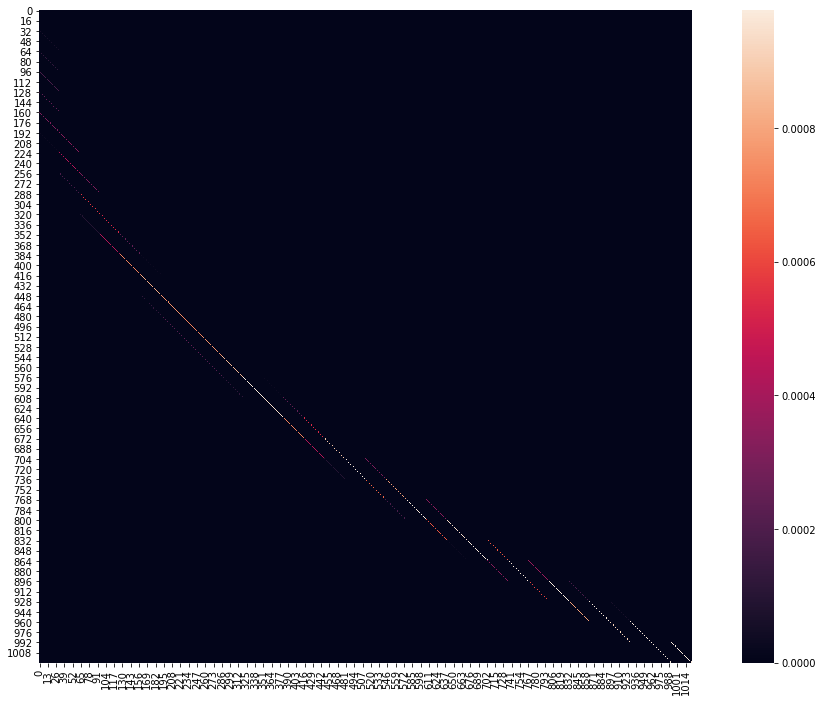

In [15]:
plt.gcf().set_size_inches(18,12)
plt.gca().set_aspect('equal')
sns.heatmap(sol)